# Multiclass MLP Classifier Implementation

A bit of copypasta from Jasmine's code:

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

plt.rc("font", size=14) 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#from mpl_toolkits.basemap import Basemap


import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests


In [2]:
ride_ids = ['15692']


#ride_ids = ['14827']
# 14743 - Motion Control July 10th
# 14750 - Magnetometer Control July 11th
# 14814 - Pool Displacement Control July 17th
# 14815 - Compass Orientation (Lying on Charger Side) July 19th
# 14816 - Orientation w Higher Sampling (Lying on Charger Side) July 20th
# 14827 - Pool Displacement Control w Higher Sampling (Jul 23)
# 14888 - First Buoy Calibration Experiment (July 30)
# 15218 - Jasmine's Second Ride Sesh filmed with GoPro (Aug 29) //no footage
# 15629 - Jasmine's First Ride Sesh filmed with VIRB (Oct. 24) //first labelled footage!
# 15669 - Jasmine's Second Ride Sesh filmed with VIRB (Nov. 7) //second labelled footage!
# 15692 - Jasmine's 3rd Ride Sesh filmed with VIRB (Nov. 9) //third labelled footage!
# 15686 - Jasmine's 4th Ride Sesh filmed with VIRB (Nov. 11) //fourth labelled footage!


In [3]:
#%% Fin ID scraper
# Input fin ID, get all ride IDs
# base URL to which we'll append given fin IDs
fin_url_base = 'http://surf.smartfin.org/fin/'

# Look for the following text in the HTML contents in fcn below
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote

#%% Ride ID scraper
# Input ride ID, get ocean and motion CSVs
# Base URL to which we'll append given ride IDs
ride_url_base = 'https://surf.smartfin.org/ride/'

# Look for the following text in the HTML contents in fcn below
str_id_csv = 'img id="temperatureChart" class="chart" src="' 

def get_csv_from_ride_id(rid):
    # Build URL for each individual ride
    ride_url = ride_url_base+str(rid)
    print(ride_url)
    
    # Get contents of ride_url
    html_contents = requests.get(ride_url).text
    
    # Find CSV identifier 
    loc_csv_id = html_contents.find(str_id_csv)
    
    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]
        
    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]
    
#    print(csv_id_longstr)
    
    # Stitch together full URL for CSV
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything
        
        ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
        motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'
        
        print(ocean_csv_url)
        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
        elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
        ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')
        
        motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])
        
        # Reindex on timestamp if there are at least a few rows
        if len(ocean_df_small) > 1:
            ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            
            #print(ocean_df_small)
            #print(motion_df_small)
            
            #May need to change this sampling interval:
            sample_interval = '33ms'
            
            
            ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
            motion_df_small_resample = motion_df_small.resample(sample_interval).mean()
            
            # No need to save many extra rows with no fix
            motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]
            
            return ocean_df_small_resample, motion_df_small_resample

    else:
        ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
        motion_df_small_resample = pd.DataFrame() 
        return ocean_df_small_resample, motion_df_small_resample
    
appended_ocean_list = [] # list of DataFrames from original CSVs
appended_motion_list = []
appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

## Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
## (Here, ride IDS are either ocean or motion dataframes)
count_good_fins = 0
    
# Loop over ride_ids and find CSVs
for rid in ride_ids:
    try:
        new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
        #print(len(new_ocean_df))
        #print(len(new_motion_df))
        if not new_ocean_df.empty: # Calibration rides, for example
            # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
            appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
            appended_ocean_list.append(new_ocean_df)
            appended_motion_list.append(new_motion_df)
            print("Ride data has been uploaded.")
            #print("Ride: ", rid, "data has been uploaded.")
            count_good_fins += 1
        
    except: 
        print("Ride threw an exception!")
        #print("Ride ", rid, "threw an exception!")    

#%% Build the "Master" DataFrame

# appended_ocean_df.summary()
df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, a list which data in it cannot be changed
ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])


##Here, maybe just use info from the motion_df and don't worry about ocean_df data for now.
##If you do want ocean_df data, look at how Phil was getting it from "July 10th and 11th Calibration" jupyter notebook file.

#We can also check to see if the surfboard was recording "in-water-freq" or 
#"out-of-water-freq" based on how many NaN values we see. 
motion_df.head(10)

https://surf.smartfin.org/ride/15692
https://surf.smartfin.org/media/201811/google_105349665704999793400_0006667E229D_181109191556_Ocean.CSV
Ride data has been uploaded.


Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:03.822           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.855           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.888           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.921           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.954           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.987           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:04.020           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.086           NaN     NaN     NaN     NaN     NaN   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789  -124.0   -86.0  -309.0   209.0    39.0   
        2018-11-09 19:16:03.822     NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.855     NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.888     NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.921     NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.954     NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.987     NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:04.020     NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:04.053   -36.0   -92.0  -320.0   194.0    38.0   
        2018-11-09 19:16:04.086     NaN     NaN     NaN     NaN     NaN   

                                  Latitude   Longitude  
ride_id UTC                                             
15692   2018-11-09 19:16:03.789  3285871.0 -11725690.0  
        2018-11-09 19:16:03.822        NaN         NaN  
        2018-11-09 19:16:03.855        NaN         NaN  
        2018-11-09 19:16:03.888        NaN         NaN  
        2018-11-09 19:16:03.921        NaN         NaN  
        2018-11-09 19:16:03.954        NaN         NaN  
        2018-11-09 19:16:03.987        NaN         NaN  
        2018-11-09 19:16:04.020        NaN         NaN  
        2018-11-09 19:16:04.053        NaN         NaN  
        2018-11-09 19:16:04.086        NaN         NaN

In [4]:
#Drop the latitude and longitude values since most of them are Nan:
motion_df_dropped = motion_df.drop(columns=['Latitude', 'Longitude'])


#Drop the NAN values from the motion data:
motion_df_dropped = motion_df_dropped.dropna(axis=0, how='any')
motion_df_dropped.head(10)

Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  
ride_id UTC                                                              
15692   2018-11-09 19:16:03.789  -124.0   -86.0  -309.0   209.0    39.0  
        2018-11-09 19:16:04.053   -36.0   -92.0  -320.0   194.0    38.0  
        2018-11-09 19:16:04.284   -63.0   -42.0  -329.0   189.0    49.0  
        2018-11-09 19:16:04.548   -92.0   -37.0  -330.0   180.0    64.0  
        2018-11-09 19:16:04.812  -233.0  -229.0  -325.0   161.0    97.0  
        2018-11-09 19:16:05.043  -376.0  -397.0  -337.0   117.0   151.0  
        2018-11-09 19:16:05.307  -527.0  -465.0  -311.0    25.0   217.0  
        2018-11-09 19:16:05.571  -662.0  -305.0  -238.0    -8.0   272.0  
        2018-11-09 19:16:05.802  -643.0  -153.0  -159.0   -21.0   321.0  
        2018-11-09 19:16:06.066  -430.0   132.0   -86.0   -38.0   326.0

In [5]:
#Create an elapsed_timedelta field:

#timedelta_values = (motion_df_dropped['Time']-motion_df_dropped['Time'][0])
#motion_df_dropped.insert(loc=1, column='TimeDelta', value=timedelta_values, drop=True)
motion_df_dropped['TimeDelta'] = (motion_df_dropped['Time']-motion_df_dropped['Time'][0])
#print(elapsed_timedelta)
#motion_df_dropped.head()
motion_df_dropped.head(10)

Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789  -124.0   -86.0  -309.0   209.0    39.0   
        2018-11-09 19:16:04.053   -36.0   -92.0  -320.0   194.0    38.0   
        2018-11-09 19:16:04.284   -63.0   -42.0  -329.0   189.0    49.0   
        2018-11-09 19:16:04.548   -92.0   -37.0  -330.0   180.0    64.0   
        2018-11-09 19:16:04.812  -233.0  -229.0  -325.0   161.0    97.0   
        2018-11-09 19:16:05.043  -376.0  -397.0  -337.0   117.0   151.0   
        2018-11-09 19:16:05.307  -527.0  -465.0  -311.0    25.0   217.0   
        2018-11-09 19:16:05.571  -662.0  -305.0  -238.0    -8.0   272.0   
        2018-11-09 19:16:05.802  -643.0  -153.0  -159.0   -21.0   321.0   
        2018-11-09 19:16:06.066  -430.0   132.0   -86.0   -38.0   326.0   

                                 TimeDelta  
ride_id UTC                                 
15692   2018-11-09 19:16:03.789        0.0  
        2018-11-09 19:16:04.053      252.5  
        2018-11-09 19:16:04.284      501.5  
        2018-11-09 19:16:04.548      753.5  
        2018-11-09 19:16:04.812     1003.5  
        2018-11-09 19:16:05.043     1253.5  
        2018-11-09 19:16:05.307     1504.5  
        2018-11-09 19:16:05.571     1755.5  
        2018-11-09 19:16:05.802     2006.5  
        2018-11-09 19:16:06.066     2258.5

In [6]:
#Footage sync code written by Alina:

import time

#simple method: only walking, paddling, floating, surfing
#complex method: columns created based on footage file labels
def label_data( footage_file = 'Footage.txt', labelling_method = 'simple', sync_threshold = 20000 ):
    
    #First, perform sync
    sync_buf = 0
    with open(footage_file) as file:
        for line in file:
            labelled_time = line.split(None, 2) 
            try:
                cur_time = time.strptime(labelled_time[0], '%M:%S')
            except:
                continue
            labelled_time[1] = labelled_time[1].rstrip()
            if labelled_time[1].lower() == 'sync': #Assumption that first word in sync line is "sync"
                sync_time = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000
                index = 0
                start = 0
                end = 0
                #Syncing occurs when IMU A2 data is negative for a longer period than the provided threshold
                #Default is 20 seconds
                for data in motion_df_dropped['IMU A2']:
                    if data < 0 and start == 0:
                        start = motion_df_dropped['TimeDelta'][index]
                    elif data > 0 and start != 0:
                        end = motion_df_dropped['TimeDelta'][index]
                        if end - start > sync_threshold:
                            sync_buf = start - sync_time
                            break
                        start = 0
                    index += 1

    accepted_labels = set()
    if labelling_method == 'simple':
        accepted_labels = {'WALKING', 'PADDLING', 'FLOATING', 'SURFING', 'SYNC (FLIP BOARD UPSIDE DOWN TO SYNC DATA/FOOTAGE)'}

        #Create new DataFrame containing label info
        label_frame = pd.DataFrame(0, index = motion_df_dropped.index, columns = accepted_labels)
        for label in accepted_labels:
            label_frame[label] = [0] * len(motion_df_dropped['Time'])
    
    #Convention of labelled footage text: "MINUTE:SECOND LABEL"
    elapsed_time = 0
    cur_label = ''
    buffer = 0
    with open(footage_file) as file:
        for line in file:
            
            if labelling_method == 'simple':
                labelled_time = line.split(None, 2) #simple categorizes on a one-word basis
            else:
                labelled_time = line.split(None, 1) #complex requires the entire label
                
            #If the first word is not a properly formatted time, the line cannot be read
            try:
                cur_time = time.strptime(labelled_time[0], '%M:%S')
                cur_timeMS = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000 + sync_buf
            except:
                continue
            labelled_time[1] = labelled_time[1].rstrip() #Remove potential newline
                
            #Check for end of video and modify buffer accordingly
            if labelled_time[1].lower() == 'end of video': #Assumption that label end video with "end of video"
                buffer += cur_timeMS
                
            #Modify accepted labels list if reading a new label and in complex mode
            elif labelling_method == 'complex' and (labelled_time[1].upper() not in accepted_labels):
                accepted_labels.add(labelled_time[1].upper())
                if not cur_label:
                    label_frame = pd.DataFrame(0, index = motion_df_dropped.index, columns = accepted_labels)
                label_frame[labelled_time[1].upper()] = [0] * len(motion_df_dropped['Time'])
                
            if labelled_time[1].upper() in accepted_labels:
                while (elapsed_time < len(motion_df_dropped['Time']) and
                      (np.isnan(motion_df_dropped['TimeDelta'][elapsed_time]) or
                       motion_df_dropped['TimeDelta'][elapsed_time] < cur_timeMS + buffer)):
                    if cur_label != '':
                        label_frame[cur_label][elapsed_time] = 1
                    elapsed_time += 1
                if labelled_time[1].upper() != 'end of video':
                    cur_label = labelled_time[1].upper()

    labelled = pd.concat([motion_df_dropped, label_frame], axis = 1)

    return labelled

pd.options.display.max_rows = 5000
pd.options.display.max_columns = 5000

motion_df_simple = label_data('Footage3.txt')
motion_df_simple.head(10)

Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789  -124.0   -86.0  -309.0   209.0    39.0   
        2018-11-09 19:16:04.053   -36.0   -92.0  -320.0   194.0    38.0   
        2018-11-09 19:16:04.284   -63.0   -42.0  -329.0   189.0    49.0   
        2018-11-09 19:16:04.548   -92.0   -37.0  -330.0   180.0    64.0   
        2018-11-09 19:16:04.812  -233.0  -229.0  -325.0   161.0    97.0   
        2018-11-09 19:16:05.043  -376.0  -397.0  -337.0   117.0   151.0   
        2018-11-09 19:16:05.307  -527.0  -465.0  -311.0    25.0   217.0   
        2018-11-09 19:16:05.571  -662.0  -305.0  -238.0    -8.0   272.0   
        2018-11-09 19:16:05.802  -643.0  -153.0  -159.0   -21.0   321.0   
        2018-11-09 19:16:06.066  -430.0   132.0   -86.0   -38.0   326.0   

                                 TimeDelta  WALKING  PADDLING  SURFING  \
ride_id UTC                                                              
15692   2018-11-09 19:16:03.789        0.0        0         0        0   
        2018-11-09 19:16:04.053      252.5        0         0        0   
        2018-11-09 19:16:04.284      501.5        0         0        0   
        2018-11-09 19:16:04.548      753.5        0         0        0   
        2018-11-09 19:16:04.812     1003.5        0         0        0   
        2018-11-09 19:16:05.043     1253.5        0         0        0   
        2018-11-09 19:16:05.307     1504.5        0         0        0   
        2018-11-09 19:16:05.571     1755.5        0         0        0   
        2018-11-09 19:16:05.802     2006.5        0         0        0   
        2018-11-09 19:16:06.066     2258.5        0         0        0   

                                 FLOATING  \
ride_id UTC                                 
15692   2018-11-09 19:16:03.789         0   
        2018-11-09 19:16:04.053         0   
        2018-11-09 19:16:04.284         0   
        2018-11-09 19:16:04.548         0   
        2018-11-09 19:16:04.812         0   
        2018-11-09 19:16:05.043         0   
        2018-11-09 19:16:05.307         0   
        2018-11-09 19:16:05.571         0   
        2018-11-09 19:16:05.802         0   
        2018-11-09 19:16:06.066         0   

                                 SYNC (FLIP BOARD UPSIDE DOWN TO SYNC DATA/FOOTAGE)  
ride_id UTC                                                                          
15692   2018-11-09 19:16:03.789                                                  0   
        2018-11-09 19:16:04.053                                                  0   
        2018-11-09 19:16:04.284                                                  0   
        2018-11-09 19:16:04.548                                                  0   
        2018-11-09 19:16:04.812                                                  0   
        2018-11-09 19:16:05.043                                                  0   
        2018-11-09 19:16:05.307                  

In [7]:
motion_df_complex = label_data('Footage3.txt', 'complex')
motion_df_complex.head(10)

Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789  -124.0   -86.0  -309.0   209.0    39.0   
        2018-11-09 19:16:04.053   -36.0   -92.0  -320.0   194.0    38.0   
        2018-11-09 19:16:04.284   -63.0   -42.0  -329.0   189.0    49.0   
        2018-11-09 19:16:04.548   -92.0   -37.0  -330.0   180.0    64.0   
        2018-11-09 19:16:04.812  -233.0  -229.0  -325.0   161.0    97.0   
        2018-11-09 19:16:05.043  -376.0  -397.0  -337.0   117.0   151.0   
        2018-11-09 19:16:05.307  -527.0  -465.0  -311.0    25.0   217.0   
        2018-11-09 19:16:05.571  -662.0  -305.0  -238.0    -8.0   272.0   
        2018-11-09 19:16:05.802  -643.0  -153.0  -159.0   -21.0   321.0   
        2018-11-09 19:16:06.066  -430.0   132.0   -86.0   -38.0   326.0   

                                 TimeDelta  PUSHING BOARD INTO WATER  \
ride_id UTC                                                            
15692   2018-11-09 19:16:03.789        0.0                         0   
        2018-11-09 19:16:04.053      252.5                         0   
        2018-11-09 19:16:04.284      501.5                         0   
        2018-11-09 19:16:04.548      753.5                         0   
        2018-11-09 19:16:04.812     1003.5                         0   
        2018-11-09 19:16:05.043     1253.5                         0   
        2018-11-09 19:16:05.307     1504.5                         0   
        2018-11-09 19:16:05.571     1755.5                         0   
        2018-11-09 19:16:05.802     2006.5                         0   
        2018-11-09 19:16:06.066     2258.5                         0   

                                 SYNC (FLIP BOARD UPSIDE DOWN TO SYNC DATA/FOOTAGE)  \
ride_id UTC                                                                           
15692   2018-11-09 19:16:03.789                                                  0    
        2018-11-09 19:16:04.053                                                  0    
        2018-11-09 19:16:04.284                                                  0    
        2018-11-09 19:16:04.548                                                  0    
        2018-11-09 19:16:04.812                                                  0    
        2018-11-09 19:16:05.043                                                  0    
        2018-11-09 19:16:05.307                                                  0    
        2018-11-09 19:16:05.571                                                  0    
        2018-11-09 19:16:05.802                                                  0    
        2018-11-09 19:16:06.066                                                  0    

                                 FLIP BOARD RIGHT SIDE UP  WALKING IN WATER  \
ride_id UTC                                                                   
15692   2018-11-09 19:16:03.789                         0                 0   
        2018-11-09 1

In [8]:
#correct IMU data

#make a deep copy of motion_df_labelled
df_converted = motion_df_complex.copy(deep = 'true')

#for rows in df_corrected
for row in range(0, df_converted.shape[0]):
    
    #convert acceleromters (new: m/s^2)
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A1')] *= -0.019141
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A2')] *= 0.019141
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A3')] *= 0.019141
 
    #convert gyroscopes (new: deg/s)
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G1')] /= 8.2
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G2')] /= 8.2
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G3')] /= 8.2

motion_df_complex.head(10)    

Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789  -124.0   -86.0  -309.0   209.0    39.0   
        2018-11-09 19:16:04.053   -36.0   -92.0  -320.0   194.0    38.0   
        2018-11-09 19:16:04.284   -63.0   -42.0  -329.0   189.0    49.0   
        2018-11-09 19:16:04.548   -92.0   -37.0  -330.0   180.0    64.0   
        2018-11-09 19:16:04.812  -233.0  -229.0  -325.0   161.0    97.0   
        2018-11-09 19:16:05.043  -376.0  -397.0  -337.0   117.0   151.0   
        2018-11-09 19:16:05.307  -527.0  -465.0  -311.0    25.0   217.0   
        2018-11-09 19:16:05.571  -662.0  -305.0  -238.0    -8.0   272.0   
        2018-11-09 19:16:05.802  -643.0  -153.0  -159.0   -21.0   321.0   
        2018-11-09 19:16:06.066  -430.0   132.0   -86.0   -38.0   326.0   

                                 TimeDelta  PUSHING BOARD INTO WATER  \
ride_id UTC                                                            
15692   2018-11-09 19:16:03.789        0.0                         0   
        2018-11-09 19:16:04.053      252.5                         0   
        2018-11-09 19:16:04.284      501.5                         0   
        2018-11-09 19:16:04.548      753.5                         0   
        2018-11-09 19:16:04.812     1003.5                         0   
        2018-11-09 19:16:05.043     1253.5                         0   
        2018-11-09 19:16:05.307     1504.5                         0   
        2018-11-09 19:16:05.571     1755.5                         0   
        2018-11-09 19:16:05.802     2006.5                         0   
        2018-11-09 19:16:06.066     2258.5                         0   

                                 SYNC (FLIP BOARD UPSIDE DOWN TO SYNC DATA/FOOTAGE)  \
ride_id UTC                                                                           
15692   2018-11-09 19:16:03.789                                                  0    
        2018-11-09 19:16:04.053                                                  0    
        2018-11-09 19:16:04.284                                                  0    
        2018-11-09 19:16:04.548                                                  0    
        2018-11-09 19:16:04.812                                                  0    
        2018-11-09 19:16:05.043                                                  0    
        2018-11-09 19:16:05.307                                                  0    
        2018-11-09 19:16:05.571                                                  0    
        2018-11-09 19:16:05.802                                                  0    
        2018-11-09 19:16:06.066                                                  0    

                                 FLIP BOARD RIGHT SIDE UP  WALKING IN WATER  \
ride_id UTC                                                                   
15692   2018-11-09 19:16:03.789                         0                 0   
        2018-11-09 1

In [9]:
df_converted.head(10)

Time     IMU A1    IMU A2    IMU A3  \
ride_id UTC                                                                    
15692   2018-11-09 19:16:03.789  1.414743e+09  -9.436513  0.918768  2.105510   
        2018-11-09 19:16:04.053  1.414743e+09  -9.819333  1.703549  1.186742   
        2018-11-09 19:16:04.284  1.414743e+09  -9.455654  1.760972  1.531280   
        2018-11-09 19:16:04.548  1.414744e+09  -8.058361  3.923905 -1.990664   
        2018-11-09 19:16:04.812  1.414744e+09 -10.221294  5.857146 -0.612512   
        2018-11-09 19:16:05.043  1.414744e+09  -8.709155  2.852009 -1.952382   
        2018-11-09 19:16:05.307  1.414744e+09  -9.072834  6.546222 -4.191879   
        2018-11-09 19:16:05.571  1.414745e+09  -6.948183  6.182543 -2.507471   
        2018-11-09 19:16:05.802  1.414745e+09   0.401961  9.761910 -8.556027   
        2018-11-09 19:16:06.066  1.414745e+09  -0.669935  5.416903 -2.526612   

                                    IMU G1     IMU G2     IMU G3  IMU M1  \
ride_id UTC                                                                
15692   2018-11-09 19:16:03.789   9.146341 -15.121951 -10.487805  -309.0   
        2018-11-09 19:16:04.053   4.146341  -4.390244 -11.219512  -320.0   
        2018-11-09 19:16:04.284   8.414634  -7.682927  -5.121951  -329.0   
        2018-11-09 19:16:04.548  23.414634 -11.219512  -4.512195  -330.0   
        2018-11-09 19:16:04.812 -51.341463 -28.414634 -27.926829  -325.0   
        2018-11-09 19:16:05.043 -43.292683 -45.853659 -48.414634  -337.0   
        2018-11-09 19:16:05.307 -28.536585 -64.268293 -56.707317  -311.0   
        2018-11-09 19:16:05.571   7.317073 -80.731707 -37.195122  -238.0   
        2018-11-09 19:16:05.802   9.512195 -78.414634 -18.658537  -159.0   
        2018-11-09 19:16:06.066 -13.902439 -52.439024  16.097561   -86.0   

                                 IMU M2  IMU M3  TimeDelta  \
ride_id UTC                                                  
15692   2018-11-09 19:16:03.789   209.0    39.0        0.0   
        2018-11-09 19:16:04.053   194.0    38.0      252.5   
        2018-11-09 19:16:04.284   189.0    49.0      501.5   
        2018-11-09 19:16:04.548   180.0    64.0      753.5   
        2018-11-09 19:16:04.812   161.0    97.0     1003.5   
        2018-11-09 19:16:05.043   117.0   151.0     1253.5   
        2018-11-09 19:16:05.307    25.0   217.0     1504.5   
        2018-11-09 19:16:05.571    -8.0   272.0     1755.5   
        2018-11-09 19:16:05.802   -21.0   321.0     2006.5   
        2018-11-09 19:16:06.066   -38.0   326.0     2258.5   

                                 PUSHING BOARD INTO WATER  \
ride_id UTC                                                 
15692   2018-11-09 19:16:03.789                         0   
        2018-11-09 19:16:04.053                         0   
        2018-11-09 19:16:04.284                         0   
        2018-11-09 19:16:04.548                         0   
        2018-11-09 19:16:04.812                         0   
        2018-11-09 19:16:05.043                         0   
        2018-11-09 19:16:05.307                         0   
        2018-11-09 19:16:05.571                         0   
        2018-11-09 19:16:05.802                         0   
        2018-11-09 19:16:06.066                         0   

                                 SYNC (FLIP BOARD UPSIDE DOWN TO SYNC DATA/FOOTAGE)  \
ride_id UTC                                                                           
15692   2018-11-09 19:16:03.789                                                  0    
        2018-11-09 19:16:04.053                                                  0    
        2018-11-09 19:16:04.284                                                  0    
        2018-11-09 19:16:04.548                                                  0    
        2018-11-09 19:16:04.812                                                  0    
        2018-11-09 19:16:05.043                                                 

In [10]:
#Copy the converted dataset, keep the features, and create only one column that contains labels. 

print("Creating multiclass dataframe...")

#Can also add "UTC Time" and "Time Delta" columns if needed later. 
multiclass_df = df_converted[['IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 'IMU M2', 'IMU M3']].copy()
parse_df = df_converted.copy()

print(multiclass_df.head(10))
      
    
#Parse the columns of the original dataframe to extract labels into a single column for the new multiclass df. 
def parse_func(x):
    l=[]
    val = 1
    for col in parse_df:
        if x[col] == val:
            l.append(col)

    return pd.Series(l)

parse_df = parse_df.apply(parse_func, axis=1)
print(parse_df.head(100))


#Drop the 2nd column of parse_df (which has all NaN values)
cols = [1]
parse_df.drop(parse_df.columns[cols],axis=1,inplace=True)
parse_df.columns=['complex_label']
#print(parse_df.head(100))


#Concatenate the parse column with the multiclass dataframe. 
multiclass_df = pd.concat([multiclass_df, parse_df], axis=1, sort=False)
#print(multiclass_df.head(100))

#Drop the NaN rows from the beginning/end of the df.
print("Shape before dropping NA:", multiclass_df.shape)
multiclass_df = multiclass_df.dropna()
print("Shape after dropping NA:", multiclass_df.shape)
print(multiclass_df.head(10))


complex_multiclass_df = multiclass_df.copy()
print("\n Done creating complex multiclass df.")


Creating multiclass dataframe...
                                    IMU A1    IMU A2    IMU A3     IMU G1  \
ride_id UTC                                                                 
15692   2018-11-09 19:16:03.789  -9.436513  0.918768  2.105510   9.146341   
        2018-11-09 19:16:04.053  -9.819333  1.703549  1.186742   4.146341   
        2018-11-09 19:16:04.284  -9.455654  1.760972  1.531280   8.414634   
        2018-11-09 19:16:04.548  -8.058361  3.923905 -1.990664  23.414634   
        2018-11-09 19:16:04.812 -10.221294  5.857146 -0.612512 -51.341463   
        2018-11-09 19:16:05.043  -8.709155  2.852009 -1.952382 -43.292683   
        2018-11-09 19:16:05.307  -9.072834  6.546222 -4.191879 -28.536585   
        2018-11-09 19:16:05.571  -6.948183  6.182543 -2.507471   7.317073   
        2018-11-09 19:16:05.802   0.401961  9.761910 -8.556027   9.512195   
        2018-11-09 19:16:06.066  -0.669935  5.416903 -2.526612 -13.902439   

                                    IMU G2

In [11]:
#Create simple multiclass df: (Surfing, Floating, Paddling, Misc.)

simple_multiclass_df = multiclass_df.copy()

simple_multiclass_df.loc[simple_multiclass_df['complex_label'].str.contains('SURFING|PADDLING|FLOATING')==False, 'complex_label'] = 'MISC'
simple_multiclass_df.loc[simple_multiclass_df['complex_label'].str.contains('PADDLING'), 'complex_label'] = 'PADDLING'
##simple_multiclass_df.loc[simple_multiclass_df['complex_label'].str.contains('TURNING'), 'complex_label'] = 'FLOATING'


column_names = list(simple_multiclass_df)
column_names = column_names[:-1]
column_names.append("simple_label")

print(column_names)
simple_multiclass_df.columns=column_names

print(simple_multiclass_df.head(5))

simple_misc_multiclass_df = simple_multiclass_df.copy()

#Check to see that labels exist: 
simple_multiclass_df = simple_multiclass_df[simple_multiclass_df['simple_label'].str.match('FLOATING|PADDLING|SURFING')]

print(simple_multiclass_df.head(5))


['IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 'IMU M2', 'IMU M3', 'simple_label']
                                   IMU A1    IMU A2    IMU A3    IMU G1  \
ride_id UTC                                                               
15692   2018-11-09 19:16:27.945  1.684408  8.900565  3.292252 -2.682927   
        2018-11-09 19:16:28.209  1.741831  9.091975  3.521944  2.195122   
        2018-11-09 19:16:28.440  1.512139  9.187680  3.253970  0.365854   
        2018-11-09 19:16:28.704  1.588703  9.225962  3.177406  6.219512   
        2018-11-09 19:16:28.968  1.856677  9.417372  2.775445 -1.341463   

                                    IMU G2    IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                                    
15692   2018-11-09 19:16:27.945  12.560976  2.560976    80.0  -132.0    56.0   
        2018-11-09 19:16:28.209  14.390244  4.512195    70.0  -136.0    68.0   
        2018-11-09 19:16:28.440  19.268293  6.2

# Implementing the Multi-Class SVM Classifier

In [12]:
simple_multi_dataset = simple_multiclass_df.copy()

In [13]:
X = simple_multi_dataset.iloc[:, :-1].values  #selects everything until the last column listed

y = simple_multi_dataset.iloc[:, -1].values   #selects the last column 
print("X.shape:", X.shape)
print("y.shape:", y.shape)

print("y:", y)

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X.shape: (6688, 9)
y.shape: (6688,)
y: ['PADDLING' 'PADDLING' 'PADDLING' ... 'SURFING' 'SURFING' 'SURFING']
X_train shape: (6019, 9)
y_train shape: (6019,)
X_test shape: (669, 9)
y_test shape: (669,)


## Balance Using SMOTE or ADASYN:

In [14]:
## Using SMOTE: 

In [15]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print("X_resampled shape:", X_resampled.shape)
print("y_resampled shape:", y_resampled.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.1, random_state = 0)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_resampled shape: (12936, 9)
y_resampled shape: (12936,)
X_train shape: (11642, 9)
y_train shape: (11642,)
X_test shape: (1294, 9)
y_test shape: (1294,)


In [ ]:
## Using ADASYN: 

In [40]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = ADASYN().fit_resample(X, y)
print("X_resampled shape:", X_resampled.shape)
print("y_resampled shape:", y_resampled.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.1, random_state = 0)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_resampled shape: (12852, 9)
y_resampled shape: (12852,)
X_train shape: (11566, 9)
y_train shape: (11566,)
X_test shape: (1286, 9)
y_test shape: (1286,)


### Linear SVM Results on Scaled Data

In [16]:
#X_train_res, y_train_res = X_train, y_train


#We still need to scale our data since, at least according to sklearn, MLP's do not handle unscaled data well.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)


In [17]:
#******Note:**********
#** Also may need to scale the signals? So they influence the classifier the same....**
# https://stats.stackexchange.com/questions/65094/why-scaling-is-important-for-the-linear-svm-classification

from sklearn.svm import SVC 
from sklearn.metrics import classification_report, confusion_matrix 

print("Running SVM classifier...")

#There are different types of kernel for SVMs, here we are using the "linear" kernel to see how it performs.
svclassifier = SVC(kernel='linear')  
svclassifier.fit(X_train_scale, y_train) 

#Making predictions: use the predict method of the SVC class
y_pred = svclassifier.predict(X_test_scale)  
print("Done.")

#Evaluating the algorithm, using a confusion matrix: 
cm = confusion_matrix(y_test,y_pred)
print(cm)  
print(classification_report(y_test,y_pred)) 

Running SVM classifier...
Done.
[[172  91 126]
 [ 79 244 106]
 [ 95  25 356]]
              precision    recall  f1-score   support

    FLOATING       0.50      0.44      0.47       389
    PADDLING       0.68      0.57      0.62       429
     SURFING       0.61      0.75      0.67       476

   micro avg       0.60      0.60      0.60      1294
   macro avg       0.59      0.59      0.59      1294
weighted avg       0.60      0.60      0.59      1294



In [ ]:
# 10-cross Fold
#from sklearn.model_selection import cross_val_score
#score = cross_val_score(estimator = svclassifier, X = X, y = y, cv = 10)
#print("Cross Val Score: \n", score)

### Non-linear SVM Results

In [20]:
from sklearn.svm import SVC  
from sklearn.metrics import classification_report, confusion_matrix 

print("Running SVM classifier...")

#There are different types of kernel for SVMs, here we are using the "linear" kernel to see how it performs.
svclassifier = SVC(kernel='rbf')  
svclassifier.fit(X_train_scale, y_train) 

#Making predictions: use the predict method of the SVC class
y_pred = svclassifier.predict(X_test_scale)  

#This takes a really long time to run!
print("Done.")

#Evaluating the algorithm, using a confusion matrix: 
cm = confusion_matrix(y_test,y_pred)
print(cm)  
print(classification_report(y_test,y_pred)) 

Running SVM classifier...
Done.
[[248  65  76]
 [ 81 286  62]
 [ 65   5 406]]
              precision    recall  f1-score   support

    FLOATING       0.63      0.64      0.63       389
    PADDLING       0.80      0.67      0.73       429
     SURFING       0.75      0.85      0.80       476

   micro avg       0.73      0.73      0.73      1294
   macro avg       0.73      0.72      0.72      1294
weighted avg       0.73      0.73      0.72      1294



In [ ]:
# 10-cross Fold
#from sklearn.model_selection import cross_val_score
#score = cross_val_score(estimator = svclassifier, X = X, y = y, cv = 10)
#print("Cross Val Score: \n", score)

Plotting CM ...
Confusion matrix, without normalization
[[248  65  76]
 [ 81 286  62]
 [ 65   5 406]]
Normalized confusion matrix
[[0.63753213 0.16709512 0.19537275]
 [0.18881119 0.66666667 0.14452214]
 [0.13655462 0.0105042  0.85294118]]


/Users/jasminesimmons/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/jasminesimmons/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


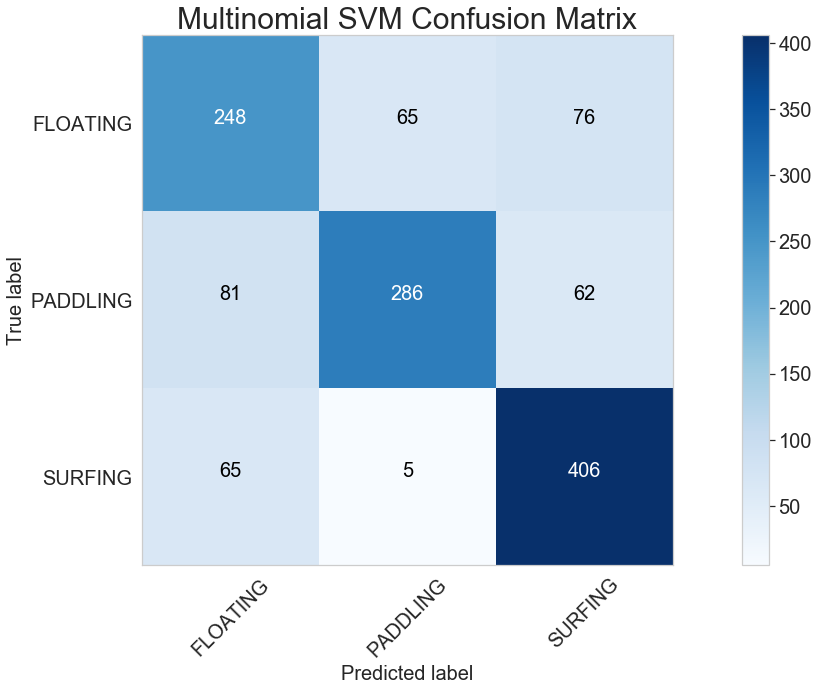

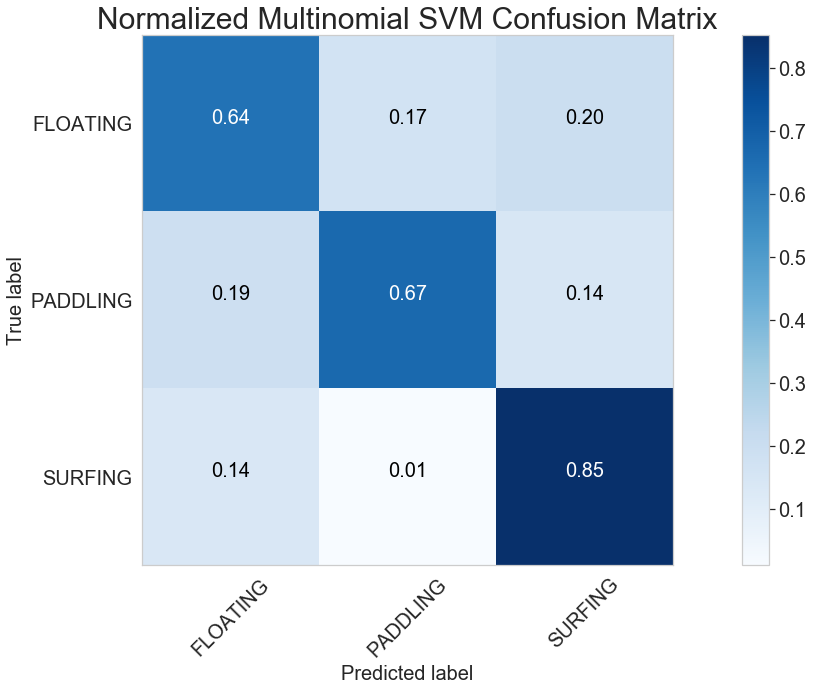

In [25]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


class_names = ["FLOATING", "PADDLING", "SURFING"]

print("Plotting CM ...")

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_test, y_pred)
#np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plt.grid('off')
plot_confusion_matrix(cm, classes=class_names,
                      title='Multinomial SVM Confusion Matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized Multinomial SVM Confusion Matrix')

plt.grid('off')

plt.show()

In [19]:
#Count the number of data points in each class: 

count_y_float = 0
count_y_paddle = 0
count_y_surf = 0

for y_val in y: 
    if y_val == "FLOATING":
        count_y_float+=1
    if y_val == "PADDLING":
        count_y_paddle+=1
    if y_val == "SURFING":
        count_y_surf+=1
        
print("Floating: ", count_y_float)
print("Paddling: ", count_y_paddle)
print("Surfing: ", count_y_surf)

Floating:  4312
Paddling:  2196
Surfing:  180


## SHOULD NOT BE USING UPSAMPLING (!!) //Discard below: 


In [ ]:

#Try upsampling the minority classes:
from sklearn.utils import resample

df_float = simple_multi_dataset[simple_multi_dataset.simple_label=="FLOATING"]
df_paddle = simple_multi_dataset[simple_multi_dataset.simple_label=="PADDLING"]
df_surf = simple_multi_dataset[simple_multi_dataset.simple_label=="SURFING"]

#print(df_paddle.head(10))

df_float_upsample = resample(df_float, replace=True, n_samples = count_y_float, random_state=123)
df_paddle_upsample = resample(df_paddle, replace=True, n_samples = count_y_float, random_state=123)
df_surf_upsample = resample(df_surf, replace=True, n_samples = count_y_float, random_state=123)

df_upsample = pd.concat([df_float_upsample, df_paddle_upsample, df_surf_upsample])

print("Upsample counts: ", df_upsample.simple_label.value_counts())

X = df_upsample.iloc[:, :-1].values  #selects everything until the last column listed

y = df_upsample.iloc[:, -1].values   #selects the last column 
print("X.shape:", X.shape)
print("y.shape:", y.shape)

print("y:", y)

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

count_y_float = 0
count_y_paddle = 0
count_y_surf = 0

for y_val in y: 
    if y_val == "FLOATING":
        count_y_float+=1
    if y_val == "PADDLING":
        count_y_paddle+=1
    if y_val == "SURFING":
        count_y_surf+=1
        
print("Floating: ", count_y_float)
print("Paddling: ", count_y_paddle)
print("Surfing: ", count_y_surf)

In [ ]:
print("Running SVM classifier...")


#There are different types of kernel for SVMs, here we are using the "linear" kernel to see how it performs.
from sklearn.svm import SVC  
svclassifier = SVC(kernel='rbf')  
svclassifier.fit(X_train, y_train) 

#Making predictions: use the predict method of the SVC class
y_pred = svclassifier.predict(X_test)  


#This takes a really long time to run!
print("Done.")

In [ ]:
#Evaluating the algorithm, using a confusion matrix: 
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 

In [ ]:
print("Upsampling doesn't actually work because the testing set has already been 'seen' since we are duplicating the training set and randomly selecting for testing.)

In [ ]:
from sklearn import svm, grid_search
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

svc_param_selection(X,y,10)